# 2×2の分割表に関するP値函数の実装例

* 黒木玄
* 2024-08-28
* Copyright (c) 2024 Gen Kuroki
* MIT License: https://licenses.opensource.jp/MIT/MIT.html

In [1]:
using Distributions
using Optim
using Printf
using Roots
using StatsFuns
using StatsPlots
default(fmt=:png)

safemul(x, y) = x == 0 ? zero(x/y) : isinf(x) ? oftype(x, Inf) : x*y
safediv(x, y) = x == 0 ? zero(x/y) : isinf(y) ? zero(y) : x/y
x ⪅ y = x < y || x ≈ y

⪅ (generic function with 1 method)

In [2]:
# Wald's method for log OR

oddsratiohat(a, b, c, d) = safediv(a*d, b*c)
stderr_logoddsratiohat(a, b, c, d) = √(1/a + 1/b + 1/c + 1/d)

function pvalue_or_wald(a, b, c, d; ω=1)
    logORhat = log(oddsratiohat(a, b, c, d))
    SEhat_logORhat = stderr_logoddsratiohat(a, b, c, d)
    2ccdf(Normal(0, 1), safediv(abs(logORhat - log(ω)), SEhat_logORhat))
end

function confint_or_wald(a, b, c, d; α=0.05)
    z = quantile(Normal(), 1-α/2)
    ORhat = oddsratiohat(a, b, c, d)
    SEhat_logORhat = stderr_logoddsratiohat(a, b, c, d)
    [safemul(exp(-z*SEhat_logORhat), ORhat), safemul(exp(z*SEhat_logORhat), ORhat)]
end

confint_or_wald (generic function with 1 method)

In [3]:
# Wald's method for log RR

riskratiohat(a, b, c, d) = safediv(a*(c+d), (a+b)*c)
stderr_logriskratiohat(a, b, c, d) = √(1/a - 1/(a+b) + 1/c - 1/(c+d))

function pvalue_rr_wald(a, b, c, d; ρ=1)
    (a+b==0 || c+d==0) && return 1.0
    logRRhat = log(riskratiohat(a, b, c, d))
    SEhat_logRRhat = stderr_logriskratiohat(a, b, c, d)
    2ccdf(Normal(0, 1), safediv(abs(logRRhat - log(ρ)), SEhat_logRRhat))
end

function confint_rr_wald(a, b, c, d; α=0.05)
    (a+b==0 || c+d==0) && return [0, Inf]
    z = quantile(Normal(), 1-α/2)
    RRhat = riskratiohat(a, b, c, d)
    SEhat_logRRhat = stderr_logriskratiohat(a, b, c, d)
    [safemul(exp(-z*SEhat_logRRhat), RRhat), safemul(exp(z*SEhat_logRRhat), RRhat)]
end

confint_rr_wald (generic function with 1 method)

In [4]:
# Wald's method for RD

riskdiffhat(a, b, c, d) = safediv(a, a+b) - safediv(c, c+d)

function stderr_riskdiffhat(a, b, c, d)
    m, n = a+b, c+d
    p̂, q̂ = safediv(a, m), safediv(c, n)
    √(safediv(p̂*(1-p̂), m) + safediv(q̂*(1-q̂), n))
end

function pvalue_rd_wald(a, b, c, d; Δ=0)
    RDhat = riskdiffhat(a, b, c, d)
    SEhat_riskdiffhat = stderr_riskdiffhat(a, b, c, d)
    2ccdf(Normal(0, 1), safediv(abs(RDhat - Δ), SEhat_riskdiffhat))
end

function confint_rd_wald(a, b, c, d; α=0.05)
    z = quantile(Normal(), 1-α/2)
    RDhat = riskdiffhat(a, b, c, d)
    SEhat_riskdiffhat = stderr_riskdiffhat(a, b, c, d)
    [RDhat - z*SEhat_riskdiffhat, RDhat + z*SEhat_riskdiffhat]
end

confint_rd_wald (generic function with 1 method)

In [5]:
# Zou-Donner method for RD

riskdiffhat_zou_donner(a, b, c, d) = safediv(a, a+b) - safediv(c, c+d)

function stderr_riskdiffhat_zou_donner(a, b, c, d; u=1)
    m, n = a+b, c+d
    p̂, q̂ = safediv(a, m), safediv(c, n)
    √(safediv(p̂*(1-p̂), m-u) + safediv(q̂*(1-q̂), n-u))
end

function pvalue_rd_zou_donner(a, b, c, d; Δ=0, u=1)
    ((a==0 && d==0) || (b==0 && c==0)) && return 1.0
    RDhat = riskdiffhat_zou_donner(a, b, c, d)
    SEhat_riskdiffhat = stderr_riskdiffhat_zou_donner(a, b, c, d; u)
    Z = safediv((1 - RDhat^2)*abs(atanh(RDhat) - atanh(Δ)), SEhat_riskdiffhat)
    2ccdf(Normal(), abs(Z))
end

function confint_rd_zou_donner(a, b, c, d; α=0.05, u=1)
    z = quantile(Normal(), 1-α/2)
    RDhat = riskdiffhat_zou_donner(a, b, c, d)
    SEhat_riskdiffhat = stderr_riskdiffhat_zou_donner(a, b, c, d; u)
    m = atanh(RDhat)
    d = safediv(z*SEhat_riskdiffhat, 1 - RDhat^2)
    [tanh(m-d), tanh(m+d)]
end

confint_rd_zou_donner (generic function with 1 method)

In [6]:
# score method for OR

function delta(a, b, c, d; ω=1)
    A, B, C = 1-ω, a+d+ω*(b+c), a*d-ω*b*c
    isinf(ω) ? oftype(ω, -min(b, c)) : safediv(2C, B + √(B^2 - 4A*C))
end

# correction = 0.5 は連続性補正を与える.
function _chisqstat_or(a, b, c, d, δ; correction=0.0)
    ã, b̃, c̃, d̃ = a-δ, b+δ, c+δ, d-δ
    safemul(max(0, abs(δ)-correction)^2, 1/ã + 1/b̃ + 1/c̃ + 1/d̃)
end

function chisqstat_or(a, b, c, d; ω=1, correction=0.0)
    δ = delta(a, b, c, d; ω)
    _chisqstat_or(a, b, c, d, δ; correction)
end

function pvalue_or_pearson_chisq(a, b, c, d; ω=1, correction=0.0)
    χ² = chisqstat_or(a, b, c, d; ω, correction)
    ccdf(Chisq(1), χ²)
end

function confint_or_pearson_chisq(a, b, c, d; α=0.05, correction=0.0)
    (a+b==0 || c+d==0 || a+c==0 || b+d==0) && return [0, Inf]
    f(logω) = logit(pvalue_or_pearson_chisq(a, b, c, d; ω=exp(logω), correction)) - logit(α)
    ps = if a == 0 || d == 0
        [0, exp(find_zero(f, 0.0))]
    elseif b == 0 || c == 0
        [exp(find_zero(f, 0.0)), Inf]
    else
        ORhat = oddsratiohat(a, b, c, d)
        ω_L, ω_U = ORhat/2, 2ORhat
        [exp(find_zero(f, log(ω_L))), exp(find_zero(f, log(ω_U)))]
    end
end

confint_or_pearson_chisq (generic function with 1 method)

In [7]:
# score method for RR

_riskratiohat(a, b, c, d) = safediv(a*(c+d), (a+b)*c)

function Delta(a, b, c, d; ρ=1.0)
    m, n = a+b, c+d
    A, B, C = ρ-1, n-a+ρ*(m-c), a*n-ρ*m*c
    Δ = isinf(ρ) ? oftype(ρ, -c) : ρ==0 ? oftype(ρ, a) : safediv(2C, B + √(B^2 - 4A*C))
end

function _chisqstat_rr(a, b, c, d, Δ)
    m, n = a+b, c+d
    safemul(Δ^2, safediv(b, m*(a-Δ)) + safediv(d, n*(c+Δ)))
end

function chisqstat_rr(a, b, c, d; ρ=1.0)
    Δ = Delta(a, b, c, d; ρ)
    _chisqstat_rr(a, b, c, d, Δ)
end

function pvalue_rr_pearson_chisq(a, b, c, d; ρ=1.0)
    χ² = chisqstat_rr(a, b, c, d; ρ)
    ccdf(Chisq(1), χ²)
end

function confint_rr_pearson_chisq(a, b, c, d; α=0.05)
    (a+b==0 || c+d==0 || a+c==0 || b+d==0) && return [0.0, Inf]
    f(logρ) = logit(pvalue_rr_pearson_chisq(a, b, c, d; ρ=exp(logρ))) - logit(α)
    L = if f(-Inf) > 0
        -Inf
    else
        logRRhat = log(_riskratiohat(a, b, c, d))
        x0 = logRRhat == -Inf ? -10.0 : logRRhat == Inf ? 10.0 : logRRhat - 1
        find_zero(f, x0)
    end
    U = if f(Inf) > 0
        Inf
    else
        logRRhat = log(_riskratiohat(a, b, c, d))
        x0 = logRRhat == -Inf ? -10.0 : logRRhat == Inf ? 10.0 : logRRhat + 1
        find_zero(f, x0)
    end
    [exp(L), exp(U)]
end

confint_rr_pearson_chisq (generic function with 1 method)

In [8]:
### score method for RD

riskdiffhat_score(a, b, c, d) = safediv(a, a+b) - safediv(c, c+d)

function loglik_rd(a, b, c, d, q, Δ=0.0)
    p = q + Δ
    safemul(a, log(p)) + safemul(b, log(1-p)) + safemul(c, log(q)) + safemul(d, log(1-q))
end

function scorestat_q_rd(a, b, c, d, q, Δ=0.0)
    p = q + Δ
    safediv(a, p) - safediv(b, 1-p) + safediv(c, q) - safediv(d, 1-q)
end

function d_scorestat_q_rd(a, b, c, d, q, Δ=0.0)
    p = q + Δ
    -safediv(a, p^2) - safediv(b, (1-p)^2) - safediv(c, q^2) - safediv(d, (1-q)^2)
end

function scorestat_Δ_rd(a, b, c, d, q, Δ=0.0)
    p = q + Δ
    safediv(a, p) - safediv(b, 1-p)
end

function estimate_q_given_Δ_rd(a, b, c, d, Δ=0.0; alg=Bisection())
    qmin, qmax = max(0.0, -Δ), min(1.0, 1.0-Δ)
    a+c==0 && return qmin
    b+d==0 && return qmax
    f(q) = scorestat_q_rd(a, b, c, d, q, Δ)
    S_qmin = f(qmin + eps())
    S_qmax = f(qmax - eps())
    S_qmin ≥ 0 && S_qmax ≥ 0 && return S_qmin < S_qmax ? qmin : qmax
    S_qmin ≤ 0 && S_qmax ≤ 0 && return S_qmin < S_qmax ? qmax : qmin
    find_zero(f, (qmin + eps(), qmax - eps()), alg)
end

function varinv_scorestat_q_rd(a, b, c, d, q, Δ=0.0)
    p = q + Δ
    safediv(p*(1-p), a+b) + safediv(q*(1-q), c+d)
end

function chisqstat_rd_score(a, b, c, d; Δ=0.0, alg=Bisection())
    Δ = clamp(Δ, -1 + eps(), 1 - eps())
    q̃ = estimate_q_given_Δ_rd(a, b, c, d, Δ; alg)
    S = scorestat_Δ_rd(a, b, c, d, q̃, Δ)
    Vinv = varinv_scorestat_q_rd(a, b, c, d, q̃, Δ)
    safemul(S^2, Vinv)
end

function pvalue_rd_score(a, b, c, d; Δ=0.0, alg=Bisection())
    χ² = chisqstat_rd_score(a, b, c, d; Δ, alg)
    ccdf(Chisq(1), χ²)
end

function confint_rd_score(a, b, c, d; α=0.05, alg=Bisection())
    χ²_α = cquantile(Chisq(1), α)
    RDhat = riskdiffhat_score(a, b, c, d)
    g(Δ) = chisqstat_rd_score(a, b, c, d; Δ, alg) - χ²_α
    L = if g(-1 + eps()) > 0
        find_zero(g, (-1 + eps(), RDhat), alg)
    else
        -1.0
    end
    U = if g(1 - eps()) > 0
        find_zero(g, (RDhat, 1 - eps()), alg)
    else
        1.0
    end
    [L, U]
end

confint_rd_score (generic function with 1 method)

In [9]:
# Fisher's method (minlike) for OR

function oddsratiohat_fisher(a, b, c, d)
    f(x) = -logpdf(FisherNoncentralHypergeometric(a+b, c+d, a+c, x[1]), a)
    ω₀ = oddsratiohat(a, b, c, d)
    o = optimize(f, [ω₀])
    o.minimizer[1]
end

_pdf_le(x, (dist, y)) =  pdf(dist, x) ⪅ y

function _search_boundary(f, x0, Δx, param)
    x = x0
    if f(x, param)
        while f(x - Δx, param) x -= Δx end
    else
        x += Δx
        while !f(x, param) x += Δx end
    end
    x
end

function pvalue_sterne(dist::DiscreteUnivariateDistribution, x)
    Px = pdf(dist, x)
    Px == 0 && return Px
    Px == 1 && return Px
    m = mode(dist)
    Px ≈ pdf(dist, m) && return one(Px)
    if x < m
        y = _search_boundary(_pdf_le, 2m - x, 1, (dist, Px))
        cdf(dist, x) + ccdf(dist, y-1)
    else # x > m
        y = _search_boundary(_pdf_le, 2m - x, -1, (dist, Px))
        cdf(dist, y) + ccdf(dist, x-1)
    end
end

function pvalue_or_sterne(a, b, c, d; ω=1)
    fnch = if ω == 1
        Hypergeometric(a+b, c+d, a+c)
    else
        FisherNoncentralHypergeometric(a+b, c+d, a+c, ω)
    end
    pvalue_sterne(fnch, a)
end

function find_pos(f, x)
    while f(x) ≤ 0
        x *= 2
    end
    x
end

function confint_or_sterne(a, b, c, d; α = 0.05)
    (a+b==0 || c+d==0 || a+c==0 || b+d==0) && return [0, Inf]
    f(logω) = logit(pvalue_or_sterne(a, b, c, d; ω=exp(logω))) - logit(α)
    if a == 0 || d == 0
        [0.0, exp(find_zero(f, (find_pos(f, -1.0), 0.0)))]
    elseif b == 0 || c == 0
        [exp(find_zero(f, (0.0, find_pos(f, 1.0)))), Inf]
    else
        ω_L, ω_U = confint_or_pearson_chisq(a, b, c, d; α = α/10)
        ps = exp.(find_zeros(f, log(ω_L), log(ω_U)))
        # 次の行は稀に区間にならない場合への対策
        [first(ps), last(ps)]
    end
end

confint_or_sterne (generic function with 1 method)

In [10]:
# Fisher's method (central) for OR

function pvalue_or_clopper_pearson(a, b, c, d; ω=1)
    fnch = if ω == 1
        Hypergeometric(a+b, c+d, a+c)
    else
        FisherNoncentralHypergeometric(a+b, c+d, a+c, ω)
    end
    min(1, 2cdf(fnch, a), 2ccdf(fnch, a-1))
end

function confint_or_clopper_pearson(a, b, c, d; α = 0.05)
    (a+b==0 || c+d==0 || a+c==0 || b+d==0) && return [0, Inf]
    f(ω) = logit(pvalue_or_clopper_pearson(a, b, c, d; ω)) - logit(α)
    if a == 0 || d == 0
        [0.0, find_zero(f, 1.0)]
    elseif b == 0 || c == 0
        [find_zero(f, 1.0), Inf]
    else
        ω_L, ω_U = confint_or_wald(a, b, c, d; α = α/10)
        find_zeros(f, ω_L, ω_U)
    end
end

confint_or_clopper_pearson (generic function with 1 method)

In [11]:
function print_results2x2(a, b, c, d; sigdigits=3, α=0.05)
    r(x) = round(x; sigdigits)
    ORhat = oddsratiohat(a, b, c, d)
    RRhat = riskratiohat(a, b, c, d)
    RDhat = riskdiffhat(a, b, c, d)
    ORhat_fisher = oddsratiohat_fisher(a, b, c, d)
    
    pval_or_wald = pvalue_or_wald(a, b, c, d)
    pval_rr_wald = pvalue_rr_wald(a, b, c, d)
    pval_rd_wald = pvalue_rd_wald(a, b, c, d)
    pval_rd_zou_donner = pvalue_rd_zou_donner(a, b, c, d)
    pval_or_score = pvalue_or_pearson_chisq(a, b, c, d)
    pval_rr_score = pvalue_rr_pearson_chisq(a, b, c, d)
    pval_rd_score = pvalue_rd_score(a, b, c, d)
    pval_or_fisher_minlike = pvalue_or_sterne(a, b, c, d)
    pval_or_fisher_central = pvalue_or_clopper_pearson(a, b, c, d)

    ci_or_wald = confint_or_wald(a, b, c, d; α)
    ci_rr_wald = confint_rr_wald(a, b, c, d; α)
    ci_rd_wald = confint_rd_wald(a, b, c, d; α)
    ci_rd_zou_donner = confint_rd_zou_donner(a, b, c, d; α)
    ci_or_score = confint_or_pearson_chisq(a, b, c, d; α)
    ci_rr_score = confint_rr_pearson_chisq(a, b, c, d; α)
    ci_rd_score = confint_rd_score(a, b, c, d; α)
    ci_or_fisher_minlike = confint_or_sterne(a, b, c, d; α)
    ci_or_fisher_central = confint_or_clopper_pearson(a, b, c, d; α)
    
    println("Data: ", [a b; c d])
    println("Null hypothesis: RD = 0,  RR = 1,  OR = 1")
    println("Confidence level: ", 100(1 - α), "%")
    println("Wald             for RD:    RDhat = $(r(RDhat)),  CI_RD = $(r.(ci_rd_wald)),  null P-value = $(r(pval_rd_wald))")
    println("Zou-Donner       for RD:    RDhat = $(r(RDhat)),  CI_RD = $(r.(ci_rd_zou_donner)),  null P-value = $(r(pval_rd_zou_donner))")
    println("Score            for RD:    RDhat = $(r(RDhat)),  CI_RD = $(r.(ci_rd_score)),  null P-value = $(r(pval_or_score))")
    println("Wald             for logRR: RRhat = $(r(RRhat)),  CI_RR = $(r.(ci_rr_wald)),  null P-value = $(r(pval_rr_wald))")
    println("Score            for RR:    RRhat = $(r(RRhat)),  CI_RR = $(r.(ci_rr_score)),  null P-value = $(r(pval_or_score))")
    println("Wald             for logOR: ORhat = $(r(ORhat)),  CI_OR = $(r.(ci_or_wald)),  null P-value = $(r(pval_or_wald))")
    println("Score            for OR:    ORhat = $(r(ORhat)),  CI_OR = $(r.(ci_or_score)),  null P-value = $(r(pval_or_score))")
    println("Fisher (minlike) for OR:    ORhat = $(r(ORhat_fisher)),  CI_OR = $(r.(ci_or_fisher_minlike)),  null P-value = $(r(pval_or_fisher_minlike))")
    println("Fisher (central) for OR:    ORhat = $(r(ORhat_fisher)),  CI_OR = $(r.(ci_or_fisher_central)),  null P-value = $(r(pval_or_fisher_central))")
end

function logtick(; xlim=(0.03, 500))
    xmin, xmax = xlim
    a = floor(Int, log10(xmin))
    b = ceil(Int, log10(xmax))
    nums =     [1, 2, 3, 4, 5, 6, 7, 8, 9]
    mask = Bool[1, 1, 0, 0, 1, 0, 0, 0, 0]
    
    logtick = foldl(vcat, ([10.0^k*x for x in nums if xmin ≤ 10.0^k*x ≤ xmax] for k in a:b))
    logticklabel_a = foldl(vcat,
        ([mask[i] ? string(round(10.0^k*x; digits=-k)) : ""
                for (i, x) in enumerate(nums) if xmin ≤ 10.0^k*x ≤ xmax]
            for k in a:-1))
    logticklabel_b = foldl(vcat,
        ([mask[i] ? string(10^k*x) : ""
                for (i, x) in enumerate(nums) if xmin ≤ 10.0^k*x ≤ xmax]
            for k in 0:b))
    logticklabel = vcat(logticklabel_a, logticklabel_b)
    (logtick, logticklabel)
end

function plot_pvaluefunctions2x2(a, b, c, d;
        size=(1000, 700), titlefontsize=12, guidefontsize=10, tickfontsize=6, ytick=0:0.1:1, kwargs...)
    RDlim = confint_rd_wald(a, b, c, d; α=0.0005)
    RD_wald = plot(Δ -> pvalue_rd_wald(a, b, c, d; Δ), RDlim...;
        label="", title="Wald for RD", xguide="RD", c=1)
    RD_zou_donner = plot(Δ -> pvalue_rd_zou_donner(a, b, c, d; Δ), RDlim...;
        label="", title="Zou-Donner for RD", xguide="RD", c=1)
    RD_score = plot(Δ -> pvalue_rd_score(a, b, c, d; Δ), RDlim...;
        label="", title="Score for RD", xguide="RD", c=1)

    RRlim = confint_rr_wald(a, b, c, d; α=0.0005)
    RRtick = logtick(; xlim=RRlim)
    RR_wald = plot(ρ -> pvalue_rr_wald(a, b, c, d; ρ), RRlim...;
        label="", title="Wald for logRR", xguide="RR (log scale)", c=2, xscale=:log10, xtick=RRtick)
    RR_score = plot(ρ -> pvalue_rr_pearson_chisq(a, b, c, d; ρ), RRlim...;
        label="", title="Score for RR", xguide="RR (log scale)", c=2, xscale=:log10, xtick=RRtick)

    ORlim = confint_or_wald(a, b, c, d; α=0.0005)
    ORtick = logtick(; xlim=ORlim)
    OR_wald = plot(ω -> pvalue_or_wald(a, b, c, d; ω), ORlim...;
        label="", title="Wald for logOR", xguide="OR", c=3, xscale=:log10, xtick=ORtick)
    OR_score = plot(ω -> pvalue_or_pearson_chisq(a, b, c, d; ω), ORlim...;
        label="", title="Score for OR", xguide="OR", c=3, xscale=:log10, xtick=ORtick)
    OR_minlike = plot(ω -> pvalue_or_sterne(a, b, c, d; ω), ORlim...;
        label="", title="Fisher (minlike) for OR", xguide="OR", c=3, xscale=:log10, xtick=ORtick)
    OR_central = plot(ω -> pvalue_or_clopper_pearson(a, b, c, d; ω), ORlim...;
        label="", title="Fisher (central) for OR", xguide="OR", c=3, xscale=:log10, xtick=ORtick)
    
    plot(RD_wald, RD_zou_donner, RD_score,
        RR_wald, RR_score,
        OR_wald, OR_score,
        OR_minlike, OR_central; 
        layout=@layout [
            a b c
            d e _
            f g _
            g i _
        ])
    plot!(; size, titlefontsize, guidefontsize, tickfontsize, ytick, kwargs...)
    plot!(; plot_title="P-value finctions")
end

function print_and_plot_results2x2(a, b, c, d; sigdigits=3, α=0.05,
        size=(1000, 1000), titlefontsize=12, guidefontsize=10, tickfontsize=6, ytick=0:0.1:1, kwargs...)
    print_results2x2(a, b, c, d; sigdigits, α)
    println()
    plot_pvaluefunctions2x2(a, b, c, d; size, titlefontsize, tickfontsize, guidefontsize, ytick, kwargs...)
end

print_and_plot_results2x2 (generic function with 1 method)

Data: [15 13; 5 15]
Null hypothesis: RD = 0,  RR = 1,  OR = 1
Confidence level: 95.0%
Wald             for RD:    RDhat = 0.286,  CI_RD = [0.0209, 0.551],  null P-value = 0.0345
Zou-Donner       for RD:    RDhat = 0.286,  CI_RD = [-0.000906, 0.529],  null P-value = 0.0507
Score            for RD:    RDhat = 0.286,  CI_RD = [0.00288, 0.519],  null P-value = 0.0478
Wald             for logRR: RRhat = 2.14,  CI_RR = [0.931, 4.93],  null P-value = 0.0732
Score            for RR:    RRhat = 2.14,  CI_RR = [1.01, 5.07],  null P-value = 0.0478
Wald             for logOR: ORhat = 3.46,  CI_OR = [0.986, 12.1],  null P-value = 0.0525
Score            for OR:    ORhat = 3.46,  CI_OR = [1.01, 11.7],  null P-value = 0.0478
Fisher (minlike) for OR:    ORhat = 3.37,  CI_OR = [0.945, 12.2],  null P-value = 0.075
Fisher (central) for OR:    ORhat = 3.37,  CI_OR = [0.856, 15.3],  null P-value = 0.0902



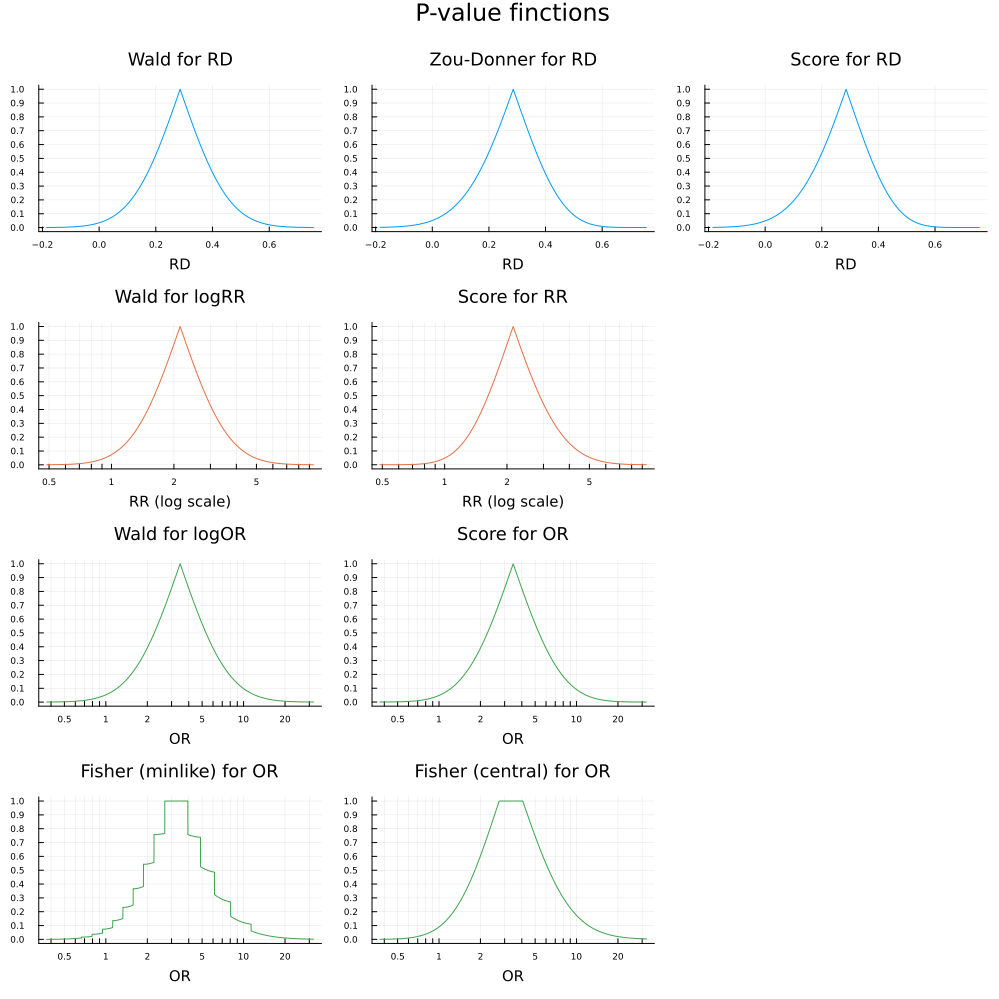

In [12]:
a, b, c, d = 15, 13, 5, 15
print_and_plot_results2x2(a, b, c, d)